Заказчик исследования - владельцы приложения Procrastinate Pro+ \
Суть исследования: 

    Приложение последние несколько месяцев приносит убытки за счёт неэффективной рекламы. Необходимо разобраться в причинах

У меня в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

##  Загрузка данных 


In [1]:
import pandas as pd # Импортируем библиотеки
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os import path

In [3]:
# Задаём переменные для данных
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [4]:
for data in [visits, orders, costs]:
    print(data.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None



Пропусков в данных нет \
Стоит изменить тип в столбцах с датами \
Взглянем на сами таблицы


In [5]:
for data in [visits, orders, costs]:
    display(data.head())
    print()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [6]:
# Приведём все названия столбцов к одному регитсру
for i in [orders, visits, costs]:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns.values]

In [7]:
# Задаём нужные типы данных в столбцах с датами
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [8]:
for i in [orders, visits, costs]:
    print(i.duplicated().sum())
    if i.duplicated().sum() == 0:
        print('Дубликатов нет')
    else:
        print('Дубликаты!')
    print()

0
Дубликатов нет

0
Дубликатов нет

0
Дубликатов нет



In [9]:
print('''Первая сессия в orders {}
Последняя сессия в orders {}'''.format(orders['event_dt'].min(), orders['event_dt'].max()))

Первая сессия в orders 2019-05-01 00:28:11
Последняя сессия в orders 2019-10-31 23:56:56


In [10]:
print('''Первая сессия в visits {}
Последняя сессия в visits {}'''.format(visits['session_start'].min(), visits['session_start'].max()))

Первая сессия в visits 2019-05-01 00:00:41
Последняя сессия в visits 2019-10-31 23:59:23


In [11]:
visits.query('session_start > session_end')

,user_id,region,device,channel,session_start,session_end


В фрейме о пользовательских сессиях нет случаев, когда конец сессии был раньше начала. Хорошо!

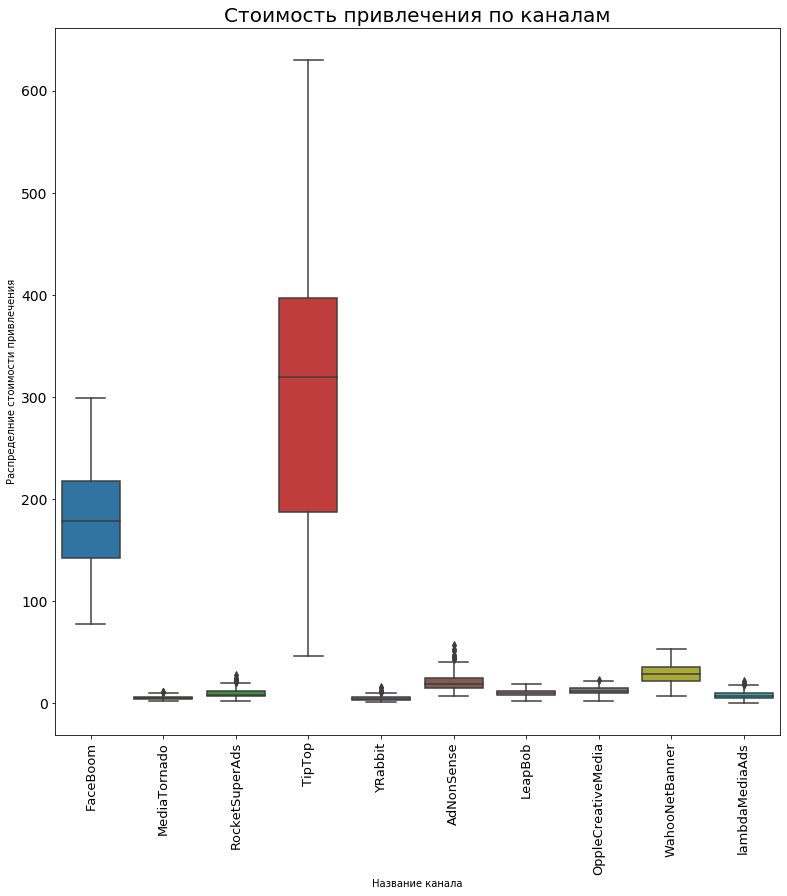

In [12]:
plt.figure(figsize=(13,13))
graph1 = sns.boxplot(x='channel', y='costs', data=costs)
plt.xticks(rotation=90, size=13)
plt.yticks(size=14)
plt.xlabel('Название канала')
plt.ylabel('Распределние стоимости привлечения')
graph1.axes.set_title('Стоимость привлечения по каналам', fontsize=20)
plt.show()

##  Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [13]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Retention 

In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.Timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Conversion

In [15]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.Timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### LTV & ROI

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.Timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Filtering

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Visulisation of retention

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Visualisation of conversion

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Visualisation of LTV & ROI

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных



In [21]:
#Создаём профили пользователей
profiles = get_profiles(sessions=visits, orders=orders, ad_costs=costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [22]:
#Т.к. необходимо найти количетсво пользователей из каждого столбца - напишем функцию
def count_users(profiles_data, list_of_cols=[]):
    for col in list_of_cols:
        #Группируем датасет по нужному столбцу и столбцу payer
        df = (
            profiles.groupby(
            col).
            agg({
                'user_id':'nunique',
                'payer':['sum','mean']})
            )
        df = df.style.format({('payer','sum'):'{:.0f}',('payer','mean'): '{:.2%}'})
        print('''Распределние платящих пользователей по {}'''.format(col))
        display(df)

In [23]:
#Вызываем функцию, передаём нужные аргументы
count_users(profiles, list_of_cols=['region', 'device', 'channel'])

Распределние платящих пользователей по region


Распределние платящих пользователей по device


Распределние платящих пользователей по channel


In [24]:
min_date_of_acquisition = profiles['dt'].min()
max_date_of_acquisition = profiles['dt'].max()
print('''Минимальная дата привлечения - {}
Максимальная дата привлечения - {}'''.format(min_date_of_acquisition, max_date_of_acquisition))

Минимальная дата привлечения - 2019-05-01
Максимальная дата привлечения - 2019-10-27


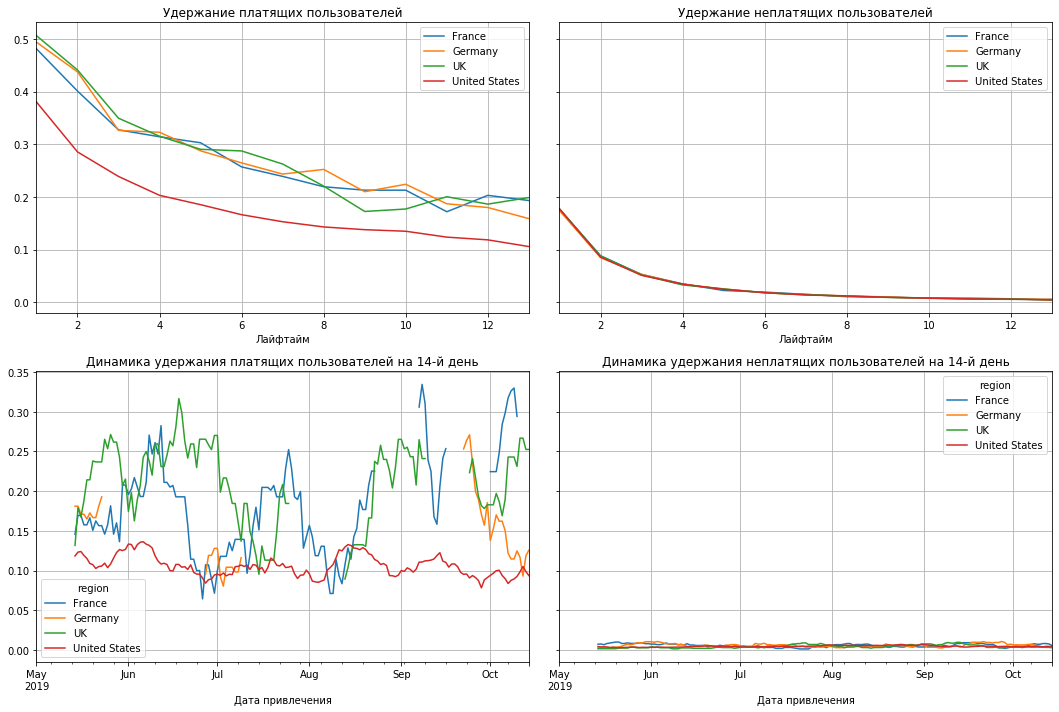

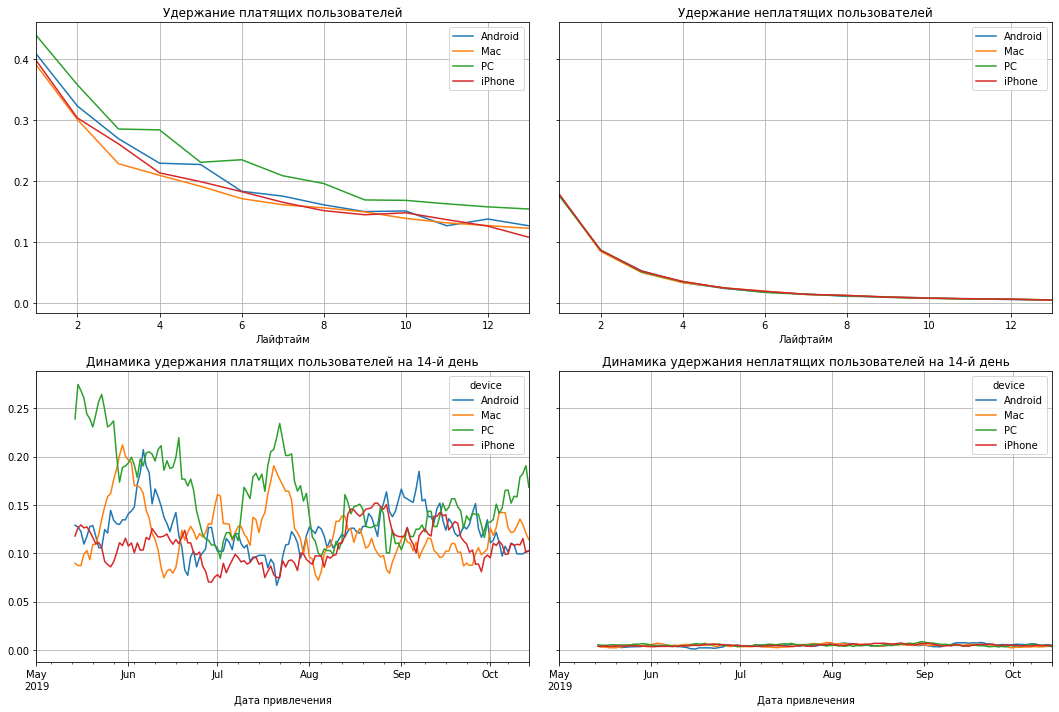

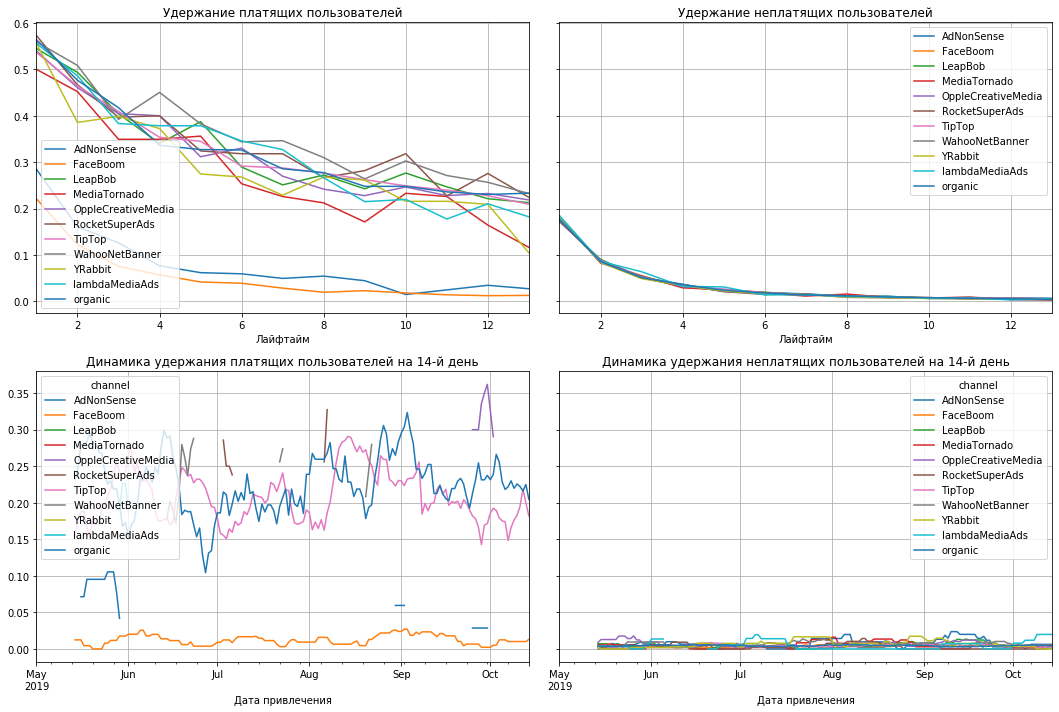

In [25]:
#Взглянем на метрики удержания..
observation_date = pd.to_datetime(profiles['dt'].max())
for col in ['region', 'device', 'channel']:
    retention_raw, retention_grouped, retention_in_time = get_retention(
        profiles, 
        visits, 
        observation_date, 
        14, 
        dimensions=[col]
    )
    plot_retention(retention_grouped, retention_in_time, 14, window=14)

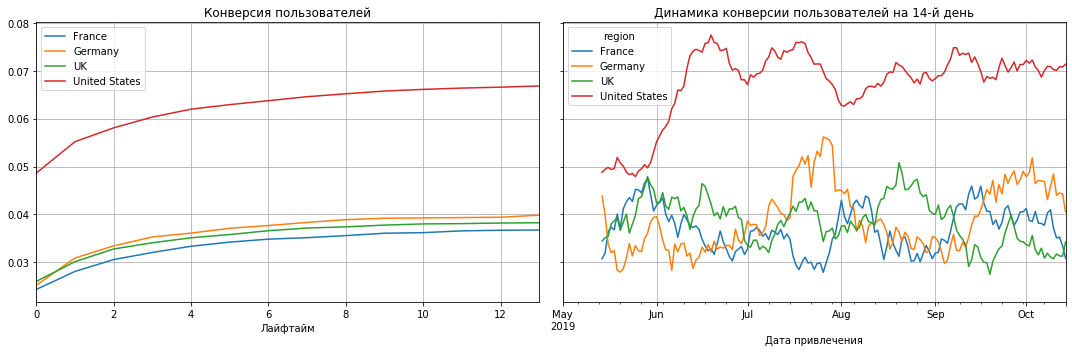

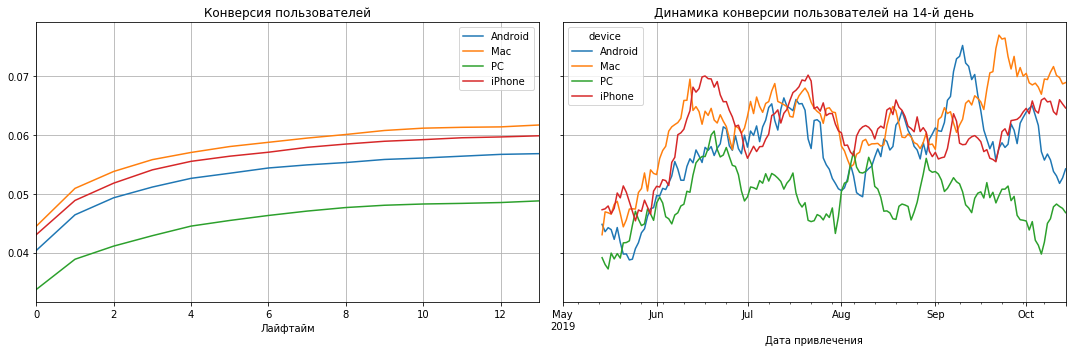

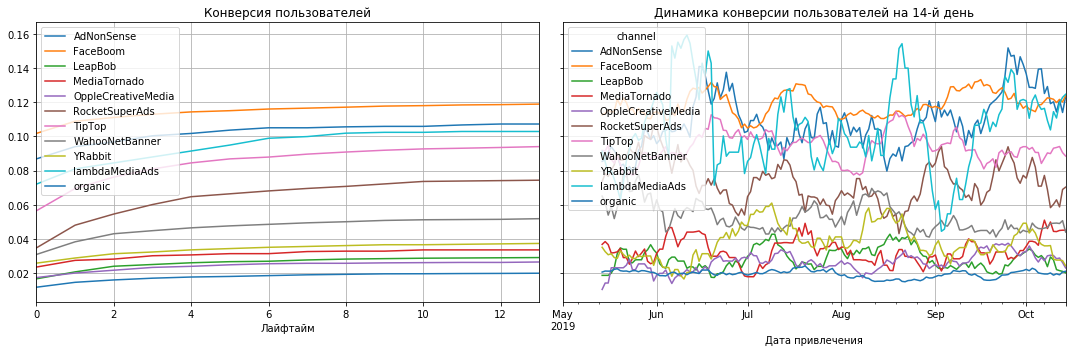

In [26]:
#И конверсии
for col in ['region', 'device', 'channel']:
    conversion_raw, conversion_grouped, conversion_in_time = get_conversion(
        profiles, 
        orders, 
        observation_date, 
        14, 
        dimensions=[col]
    )
    plot_conversion(conversion_grouped, conversion_in_time, 14, window=14)

### Вывод:
Больше всего пользователей привлечено из Америки, как платящих, так и нет. Конверсия так же показывает лучший результат в Америке. А вот удержание на рынке США хромает \
Iphone заметно ушёл вперёд по количеству пользователей, конверсия на втором месте. С удержанием у iphone есть проблемы \
Очень много органических пользователей, но у Faceboom гораздо больше доля платящих пользователей. Но удержание FaceBoom абсолютно неудовлетворительно

##  Маркетинг



In [27]:
#Общий бюджет на маркетинг
print('Общие затраты на маркетинг составили {}'.format(round(costs['costs'].sum(), 2)))

Общие затраты на маркетинг составили 105497.3


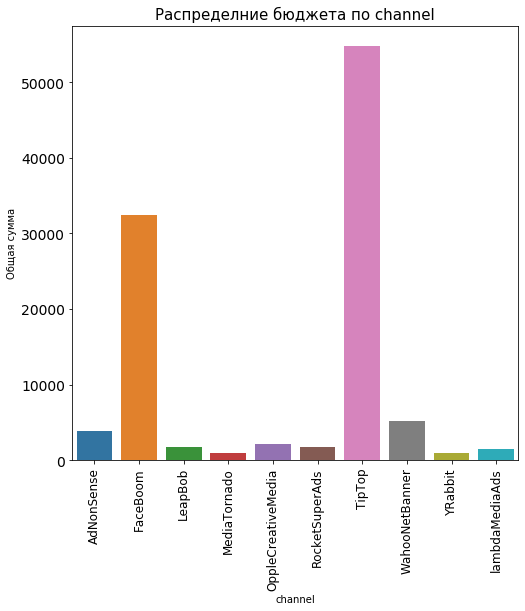

In [28]:
#Сделаем простой барплот для группирвоки по каналу привлечения
costs_grouped_by_chnl = costs.groupby('channel').sum()
sns.axes_style("ticks")
plt.figure(figsize=(8,8))
plt.xticks(rotation=90, size=12)
plt.yticks(size=14)
graph1 = sns.barplot(data=costs_grouped_by_chnl, x=costs_grouped_by_chnl.index, y='costs')
plt.ylabel('Общая сумма')
plt.xlabel(col)
graph1.axes.set_title('Распределние бюджета по {}'.format('channel'), fontsize=15)
plt.show()

In [29]:
costs_grouped_by_chnl #Для наглядности покажу весь фрейм с точными цифрами

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


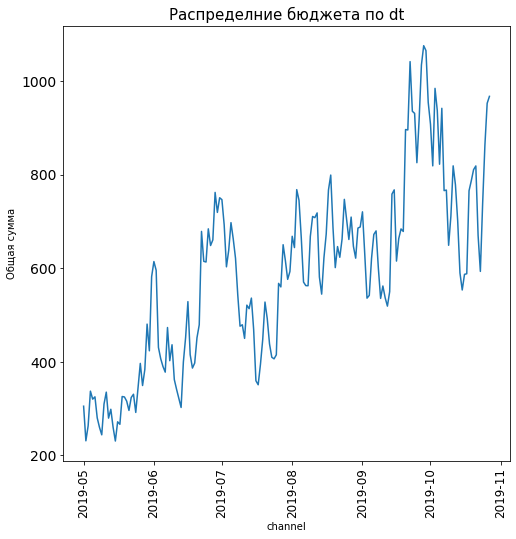

In [30]:
#Линейный график здесь подойдёт больше, т.к. нагромаждение баров будет выглядеть ужасно
costs_grouped_by_dt = costs.groupby('dt').sum()
sns.axes_style("ticks")
plt.figure(figsize=(8,8))
plt.xticks(rotation=90, size=12)
plt.yticks(size=14)
graph1 = sns.lineplot(data=costs_grouped_by_dt, x=costs_grouped_by_dt.index, y='costs')
plt.ylabel('Общая сумма')
plt.xlabel(col)
graph1.axes.set_title('Распределние бюджета по {}'.format('dt'), fontsize=15)
plt.show()

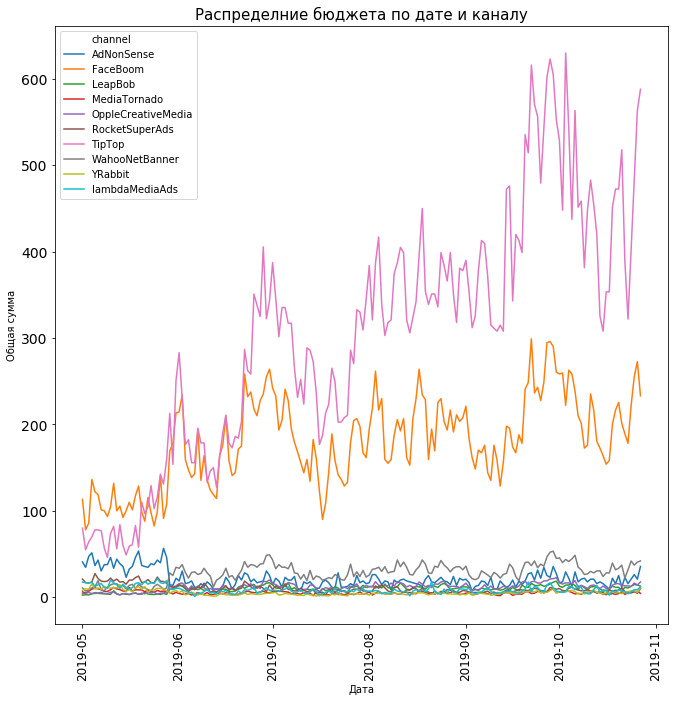

In [31]:
costs_grouped_by_dt_channel = costs.groupby(['dt','channel']).sum().reset_index()
sns.axes_style("ticks")
plt.figure(figsize=(11,11))
plt.xticks(rotation=90, size=12)
plt.yticks(size=14)
graph1 = sns.lineplot(data=costs_grouped_by_dt_channel, x='dt', y='costs', hue='channel')
plt.ylabel('Общая сумма')
plt.xlabel('Дата')
graph1.axes.set_title('Распределние бюджета по дате и каналу', fontsize=15)
plt.show()

Средняя цена привлечения без учёта органических пользователей


channel
TipTop                2.785961
FaceBoom              1.113243
AdNonSense            1.011119
lambdaMediaAds        0.735322
WahooNetBanner        0.600576
RocketSuperAds        0.418493
OppleCreativeMedia    0.250456
MediaTornado          0.217389
YRabbit               0.211338
LeapBob               0.210378
Name: acquisition_cost, dtype: float64

Средняя цена, учитывая органических пользователей


channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

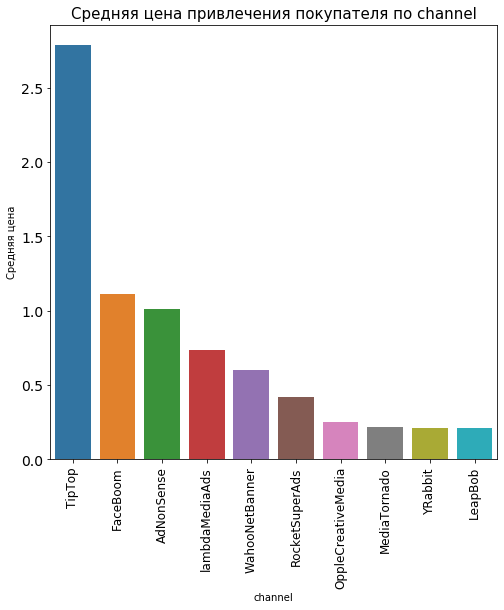

In [32]:
profiles_filtered = profiles.query('payer == True and channel != "organic"').groupby('channel').mean()
print('Средняя цена привлечения без учёта органических пользователей')
display(profiles_filtered['acquisition_cost'].sort_values(ascending=False))
print('Средняя цена, учитывая органических пользователей')
display(profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False))
sns.axes_style("ticks")
plt.figure(figsize=(8,8))
plt.xticks(rotation=90, size=12)
plt.yticks(size=14)
graph1 = sns.barplot(data=profiles_filtered,
                     x=profiles_filtered.index,
                     y='acquisition_cost',
                     order=profiles_filtered['acquisition_cost'].sort_values(ascending=False).index)
plt.ylabel('Средняя цена')
plt.xlabel(col)
graph1.axes.set_title('Средняя цена привлечения покупателя по {}'.format('channel'), fontsize=15)
plt.show()

### Вывод 
Дороже всего реклама обходится в FaceBoom и TipTop. Причём заметно так \
Можно сказать, что затраты на маркетинг имеют тенденцию к росту со временем \
Самая высокая средняя цена покупателя - из TipTop. FaceBoom имеет более умеренную цифру привлечения

## Окупаемость рекламы для привлечения пользователей


### Проанализируем общую окупаемость рекламы

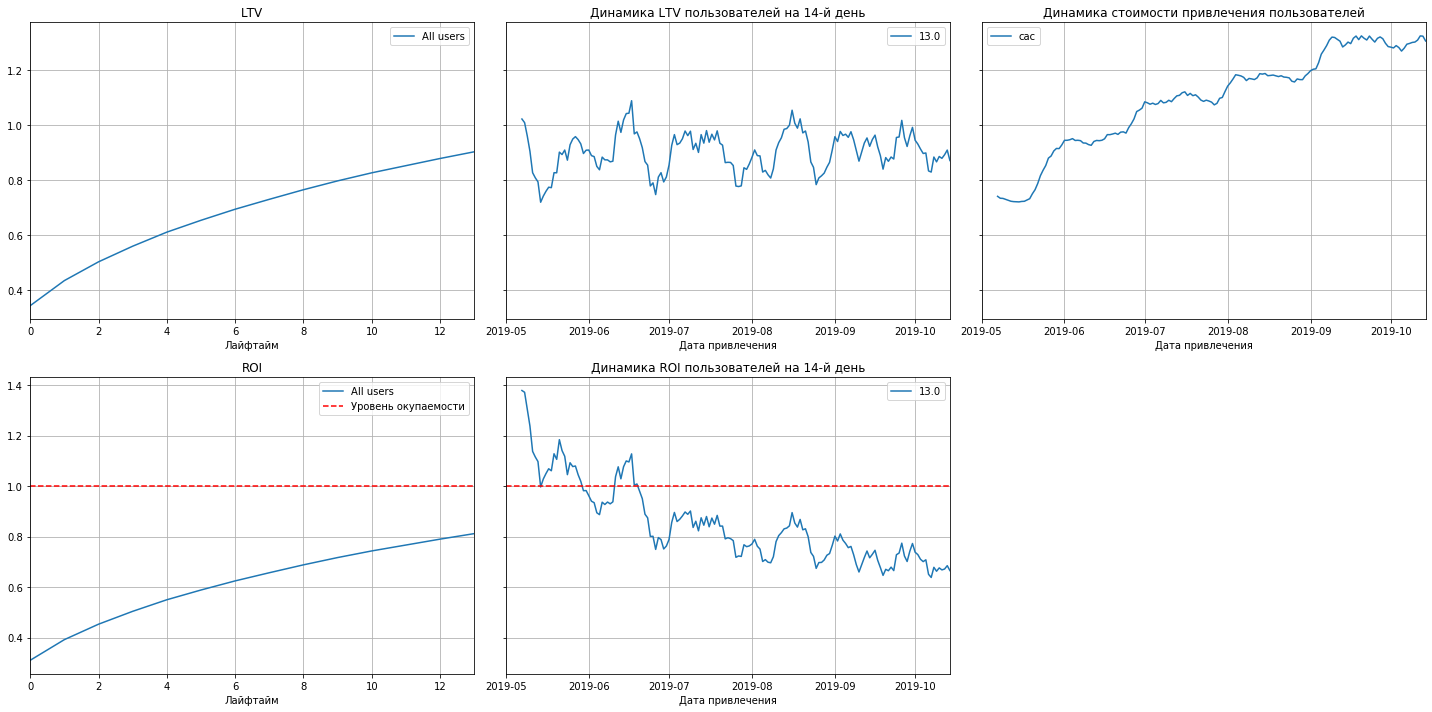

In [33]:
profiles_non_organic = profiles.query('channel != "organic"')
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_non_organic,
    orders,
    observation_date,
    14,
    dimensions=[]
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=7)

Реклама в целом, без разбивок по девайсам, каналам и проч. не окупается \
Стоимость привлечения со временем растёт, тогда как ROI падает \
Картина, прямо скажем, невесёлая

### Проанализируем окупаемость рекламы с разбивкой по устройствам

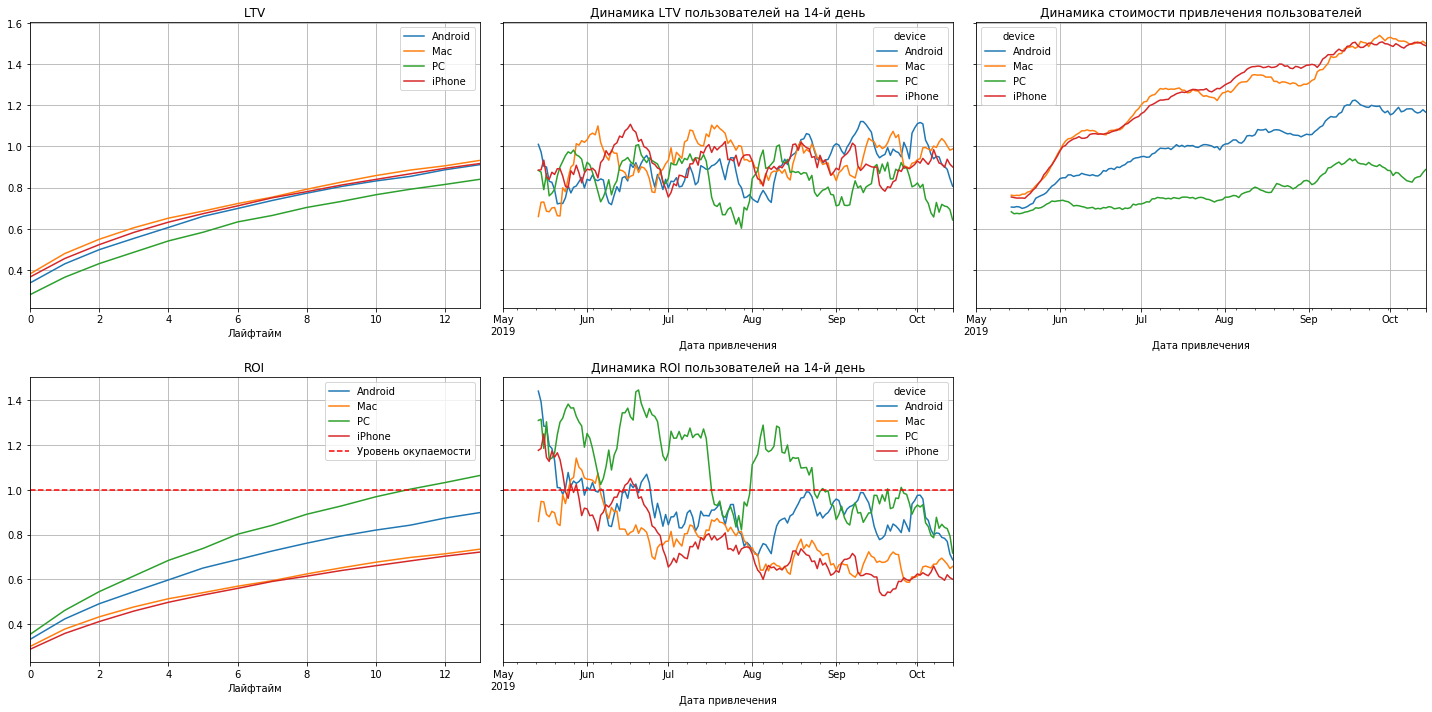

In [34]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_non_organic,
    orders,
    observation_date,
    14,
    dimensions=['device']
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=14)

При разбивке по девайсам видно, что окупается реклама только на PC, на андроиде реклама не окупается, но в целом не настолько ужасно. Мак и айфон в аутсайдерах \
Самая низкая стоимость привлечения - PC, и мак с айфоном опять же показывают худшие показатели. Андроид посередине \
ROI у всех девайсов со временем стремится к уменьшению и к нынешней дате имеют значение меньше нуля

### Проанализируем окупаемость рекламы с разбивкой по странам

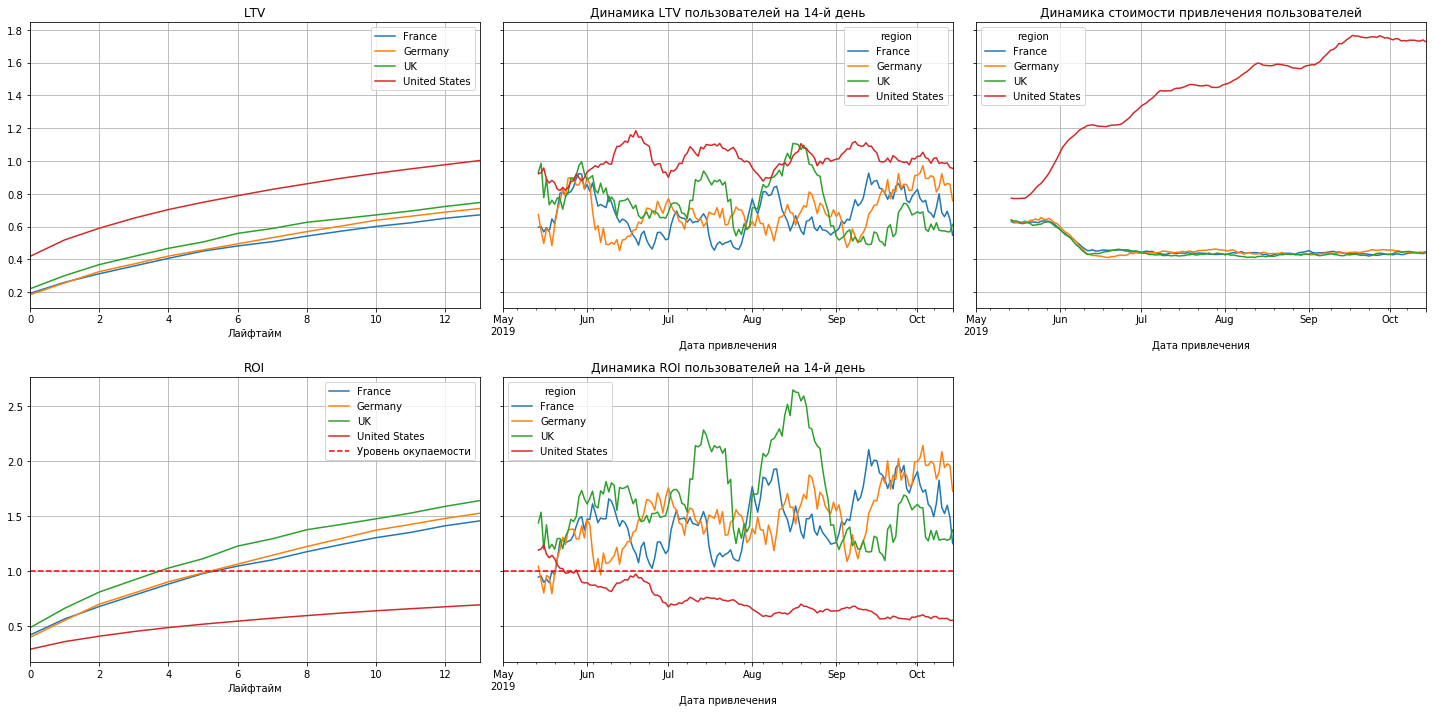

In [35]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_non_organic,
    orders,
    observation_date,
    14,
    dimensions=['region']
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=14)

В целом, если посмотреть исключительно на LTV - США вполне себе хороши. Но вот с ROI и стоимостью привлечения абсолютная беда \
У других регионов таких ярких проблем нет, даже стоимость привлечения снизилась относительно даты начала исследования

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

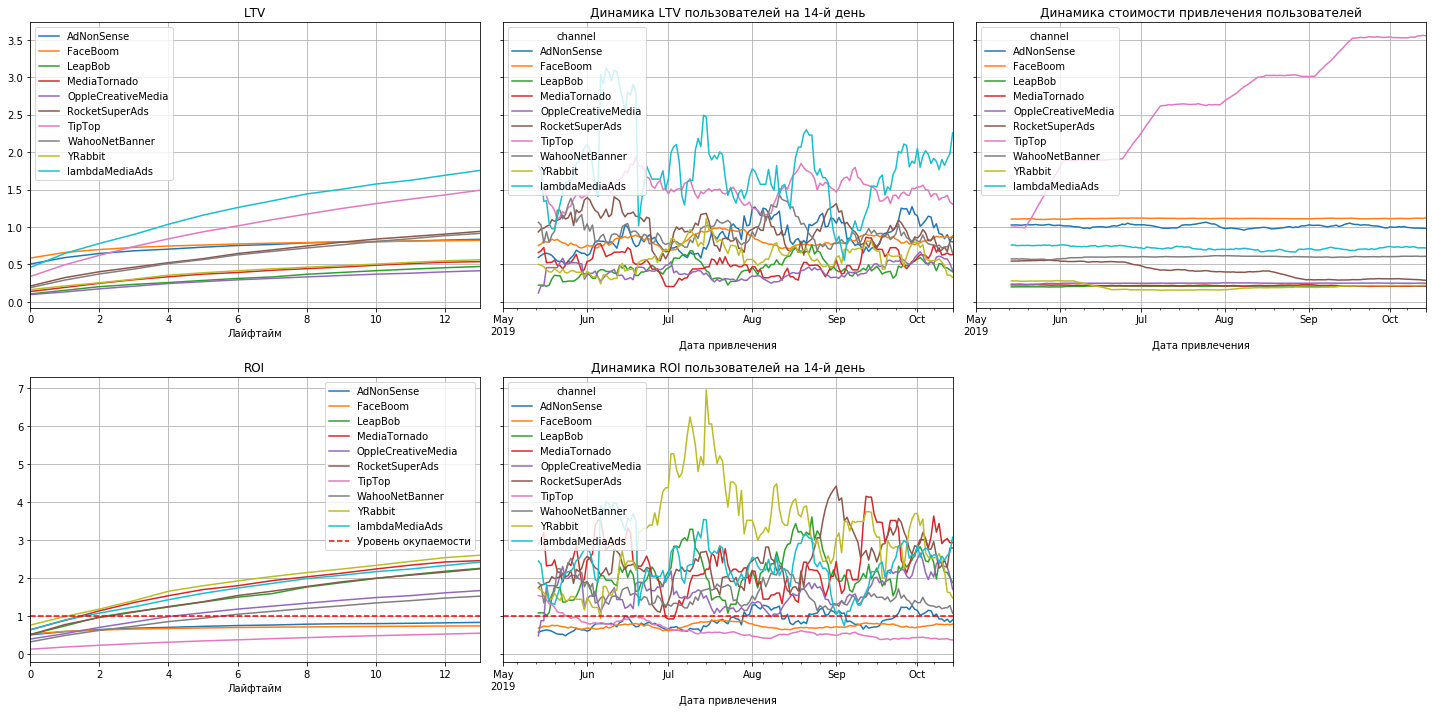

In [36]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_non_organic,
    orders,
    observation_date,
    14,
    dimensions=['channel']
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=14)

В разрезе channel видны те же проблемы, что и при рассмотрении конверсии и удержания \
TipTop - крайне дорого, не окупается \
FaceBoom - цена не менялась, но так же не окупается (скорее всего из-за низкого удержания) 


Взглянем более подробно на пользователей из США, пришедших по каналам, не органических

In [37]:
profiles_usa = profiles.query('region == "United States" and channel != "organic"')

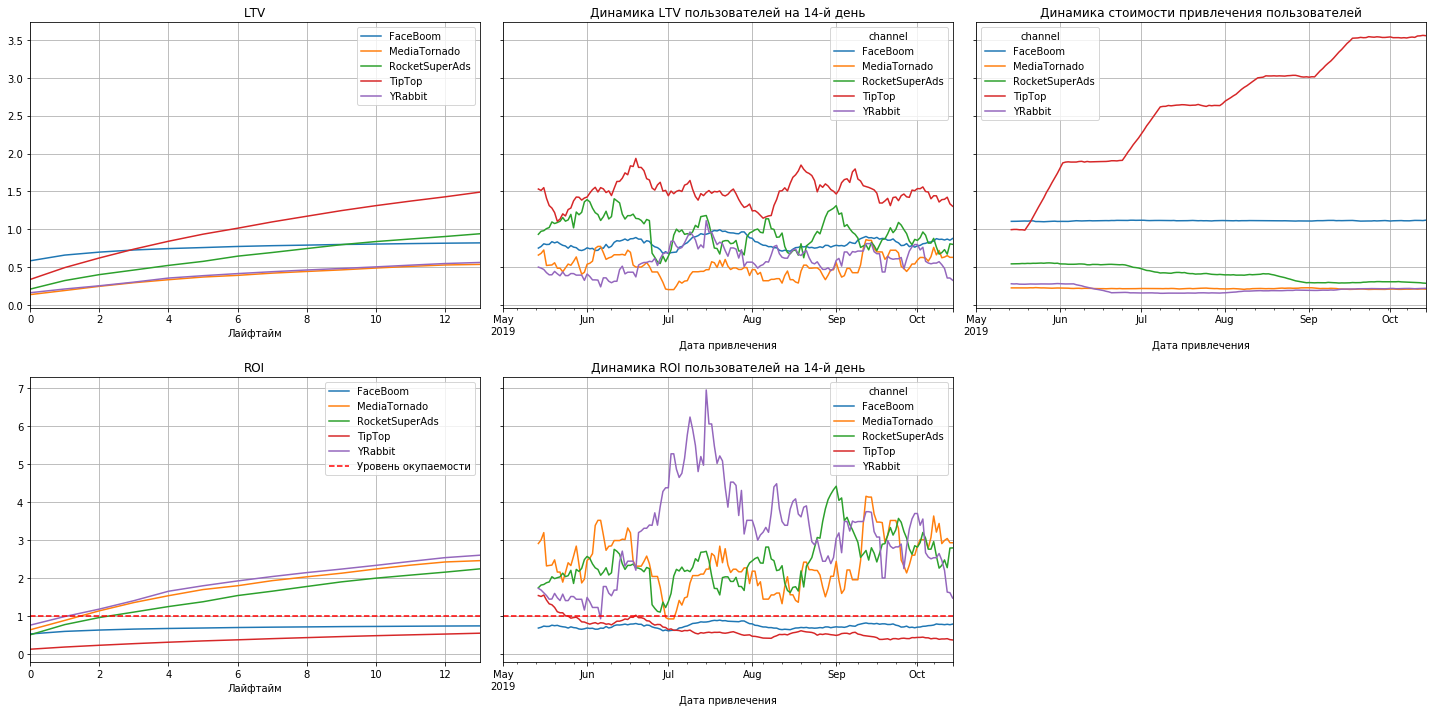

In [38]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    14,
    dimensions=['channel']
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=14)

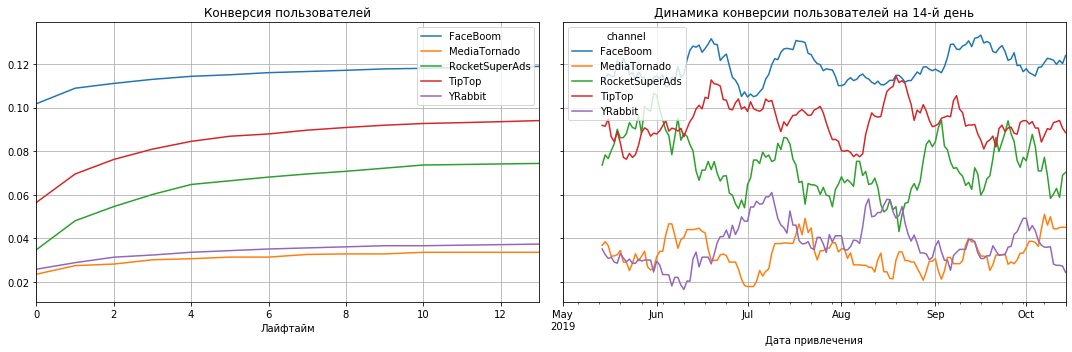

In [39]:
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(
        profiles_usa, 
        orders, 
        observation_date, 
        14, 
        dimensions=['channel']
    )
plot_conversion(conversion_grouped, conversion_in_time, 14, window=14)

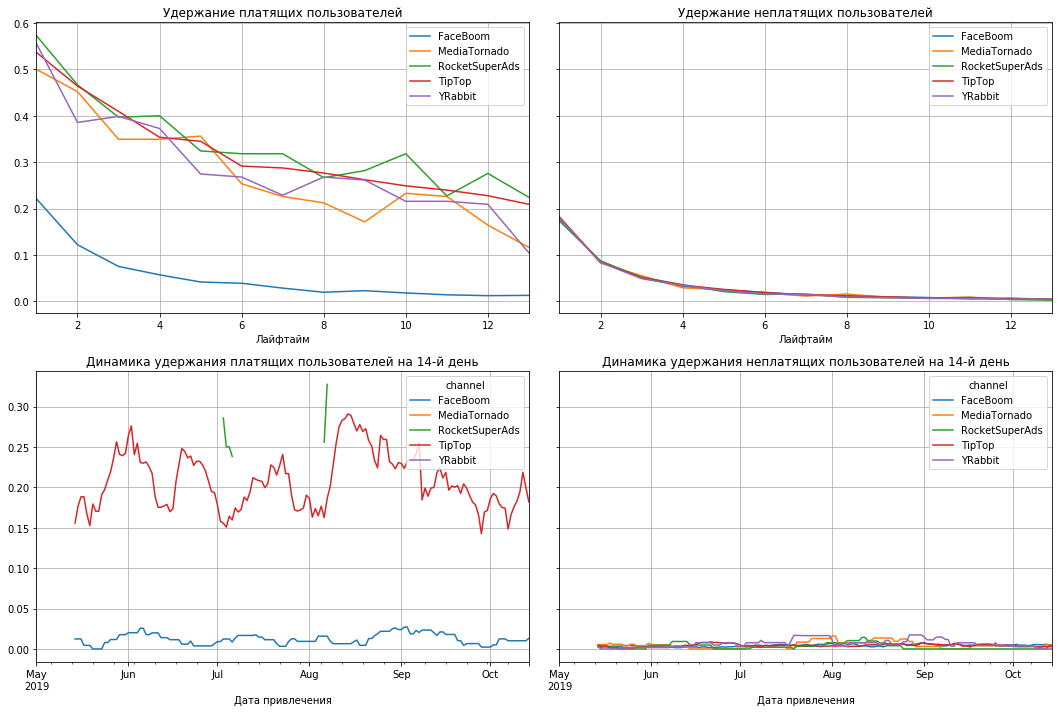

In [40]:
retention_raw, retention_grouped, retention_in_time = get_retention(
        profiles_usa, 
        visits, 
        observation_date, 
        14, 
        dimensions=['channel']
    )
plot_retention(retention_grouped, retention_in_time, 14, window=14)

In [41]:
profiles_usa.groupby('channel').agg({
                'user_id':'nunique',
                'payer':['sum','mean']}).style.format({('payer','sum'):'{:.0f}',('payer','mean'): '{:.2%}'})

В целом видно, что у ТипТоп реклама не окупается из-за высокой цены. И пусть даже он приносит много пользователей, с хорошей конверсией и удержанием, но обходится нам слишком дорого \
ФэйсБум же не так дорог, у него хорошие показатели привлечения и конверсии, но удержания практически нет 

### Ответы на поставленные вопросы
Выходит ли общие затраты на маркетинг в плюс? - нет, они не окупаются \
Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы? \
Устройства - негативное влияние на статистику оказывают пользователи iphone и mac. А вот с пользователями PC всё обстоит веселее \
Страны - пользователи из США стоят нам ооочень дорого и абсолютно не окупаются \
Каналы - не окупаются три из них (FaceBoob, TipTop, AdNonSense)

## Вывод

1) Выделите причины неэффективности привлечения пользователей: \
Большая стоимость рекламы в TipTop, FaceBoom и вместе с тем у второго низкая конверсия и удержание. Абсолютно ужасные показетели по пользователям из США. По устройствам сложно что-то сказать, но окупаемость маркетинговых инвестиций в сегменте iphone/mac не окупаются \
2) Сформируйте рекомендации для отдела маркетинга для повышения эффективности: \
Стоит уйти от рекламы в TipTop и FaceBoom или хотя бы провести анализ и изменения рекламных кампаний через эти площадки. Можно переориентироваться на рынке США на другие каналы привлечения, например RocketSuperAds. Соотношение цены и качества привлекаемых пользователей выглядит наиболее уместно. Возможно стоит проверить приложения для пользователей iphone/mac, теоретически проблемы с удержанием и конверсией могут быть связаны с багами или сложностями в приложении